# Quantum Process Tomography with Q# and Python

**NB**: This notebook requires additional packages to provide process tomography support. Dependencies for this sample can be installed as a new virtual environment by using `conda`:

```sh
conda env create -f environment.yml
conda activate process-tomography
```

## Abstract ##

In this sample, we will demonstrate using Q# and Python together with the QInfer and QuTiP libraries for Python to characterize and verify quantum processes implemented in Q#.
In particular, this sample will use *quantum process tomography* to learn about the behavior of a "noisy" Hadamard operation from the results of random Pauli measurements.

So that we have some noise to learn, we will use the open systems simulator provided with the Quantum Development Kit to simulate the action of a noisy `H` operation.

## Preamble ##

We can enable Q# support in Python by importing the `qsharp` package.

In [1]:
import qsharp
import qsharp.experimental
qsharp.experimental.enable_noisy_simulation()

Preparing Q# environment...


We'll also be using numerics in this sample, so we import NumPy as well.

In [2]:
import numpy as np

Next, we import plotting support and the QuTiP library, since these will be helpful to us in manipulating the quantum objects returned by the quantum process tomography functionality that we call later.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import qutip as qt
qt.settings.colorblind_safe = True

Finally, to run process tomography, we'll be using the [QInfer](http://qinfer.org) library, so we go on and import it here.

In [5]:
import qinfer as qi

## Tomography

We start by defining a noise model to use in simulating the `H` operation. For example, suppose that nothing happens 10% of the time we call `H`, but that the other 90% of the time, `H` works perfectly. We can use QuTiP to define a channel representing this case by using `qt.to_super` to turn unitary operators into channels, then adding the channels for each of the two possibilities.

In [6]:
noisy_h = 0.9 * qt.to_super(qt.qip.operations.hadamard_transform()) + 0.1 * qt.to_super(qt.qeye(2))
noisy_h

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
Qobj data =
[[ 0.55  0.45  0.45  0.45]
 [ 0.45 -0.35  0.45 -0.45]
 [ 0.45  0.45 -0.35 -0.45]
 [ 0.45 -0.45 -0.45  0.55]]

Once we have a channel describing the noise in our `H` operation, we can set that to the noise model used by the open systems simulator.

In [7]:
noise_model = qsharp.experimental.get_noise_model_by_name('ideal')
noise_model['h'] = noisy_h
qsharp.experimental.set_noise_model(noise_model)

We can then define a new Q# operation that takes a preparation and a measurement, then returns the result of performing that tomographic measurement on the noisy Hadamard operation that we defined the noise model for immediately above.

In [8]:
%%qsharp
open Microsoft.Quantum.Characterization;

operation DrawTomographyMeasurement(prep : Pauli, meas : Pauli) : Result {
    return SingleQubitProcessTomographyMeasurement(prep, meas, H);
}

In quantum tomography experiments, it is often helpful to select preparation and measurement bases at random [arXiv:1302.0932](https://arxiv.org/abs/1302.0932) so as to average out random drift in noise processes, so we'll next write an operation that does this random sampling within a Q# program directly, allowing us to batch up measurements with less round trips between our host and our quantum program.

In [9]:
%%qsharp
open Microsoft.Quantum.Random;
open Microsoft.Quantum.Arrays;

operation DrawTomographyMeasurementInRandomBasis() : (Pauli, Pauli, Result) {
    let prep = DrawRandomPauli();
    let meas = DrawRandomPauli();
    return (prep, meas, DrawTomographyMeasurement(prep, meas));
}

operation DrawTomographyBatch(nMeasurements : Int) : (Pauli, Pauli, Result)[] {
    return DrawMany(DrawTomographyMeasurementInRandomBasis, nMeasurements, ());
}

In [10]:
DrawTomographyBatch.simulate(nMeasurements=5)

[(0, 2, 0), (2, 0, 0), (3, 0, 0), (2, 0, 0), (3, 1, 1)]

Finally, we define a function for quantum tomography itself.

In [11]:
def projector(P):
    return (qt.qeye(2) + P) / 2.0

def single_qubit_process_tomography(
    n_measurements_per_batch=100,
    n_batches=40,
    n_particles=128_000
):

    # We start by preparing a model for quantum tomography.
    # This model predicts the output of different measurements,
    # conditioned on different hypotheses.
    print("Preparing tomography model...")
    state_basis = qi.tomography.pauli_basis(1)
    prior = qi.tomography.BCSZChoiDistribution(state_basis)
    model = qi.tomography.TomographyModel(prior.basis)

    # Once we have a model, we can define how our knowledge
    # about that model is updated with new data.
    updater = qi.SMCUpdater(model, n_particles, prior)

    # To learn the channel, we loop through each different
    # measurement and use the updater to incorporate those results.
    print("Performing tomography...")
    for idx_batch in range(n_batches):
        print(f"\tBatch {idx_batch + 1} of {n_batches}...")
        # Get a batch of measurements from our tomography operation
        # above.
        print("\t\tRunning measurements...")
        batch = DrawTomographyBatch.simulate_noise(nMeasurements=n_measurements_per_batch)
        
        # Process each of the results and update our knowledge using
        # Bayesian inference.
        print("\t\tUpdating posterior distribution...")
        for prep, meas, result in batch:
            # Convert into a QuTiP object by using the standard transformation
            # between state and process tomography.
            qobj = 2.0 * qt.tensor(
                projector(
                    qsharp.Pauli(prep).as_qobj()
                ).trans(),
                projector(
                    qsharp.Pauli(meas).as_qobj()
                )
            )
            expparams = np.array(
                [(model.basis.state_to_modelparams(qobj),)],
                dtype=model.expparams_dtype
            )
            updater.update(1 - result, expparams)
        
    return (
        # After we've collected all of our data, we can use the
        # mean (that is, the average) from our updater to estimate
        # the channel.
        # NB: We multiply by 2 to turn into a Choi–Jamiłkowski operator instead
        #     of a Choi–Jamiłkowski state.
        2.0 * model.basis.modelparams_to_state(updater.est_mean()),
        # We also return the full distribution itself so that we
        # can look at other properties such as error bars.
        updater
    )

Here, we ask for 10,000 measurements from the noisy Hadamard operation that we defined above.

> **NOTE**: The next cell may take several minutes to run.

We then plot the estimated and actual channels as Hinton diagrams, showing how each acts on the Pauli operators $X$, $Y$ and $Z$.

In [12]:
est_channel, updater = single_qubit_process_tomography()

Preparing tomography model...
Performing tomography...
	Batch 1 of 40...
		Running measurements...
		Updating posterior distribution...


C:\Users\cgran\Anaconda3\envs\process-tomography\lib\site-packages\qinfer\utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)


	Batch 2 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 3 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 4 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 5 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 6 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 7 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 8 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 9 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 10 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 11 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 12 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 13 of 40...
		Running measurements...
		Updating posterior distribution...
	Batch 14 of 40...
		Run

(None, <matplotlib.axes._subplots.AxesSubplot at 0x2133f1a12c8>)

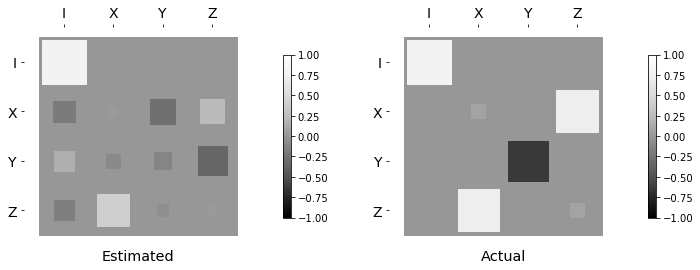

In [13]:
fig, (left, right) = plt.subplots(ncols=2, figsize=(12, 4))
plt.sca(left)
plt.xlabel('Estimated', fontsize='x-large')
qt.visualization.hinton(est_channel, ax=left)
plt.sca(right)
plt.xlabel('Actual', fontsize='x-large')
qt.visualization.hinton(noisy_h, ax=right)

We also obtain a wealth of other information as well, such as the covariance matrix over each parameter of the resulting channel.
This shows us which parameters we are least certain about, as well as how those parameters are correlated with each other.

C:\Users\cgran\Anaconda3\envs\process-tomography\lib\site-packages\mpltools\special\hinton.py:56: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('gray')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

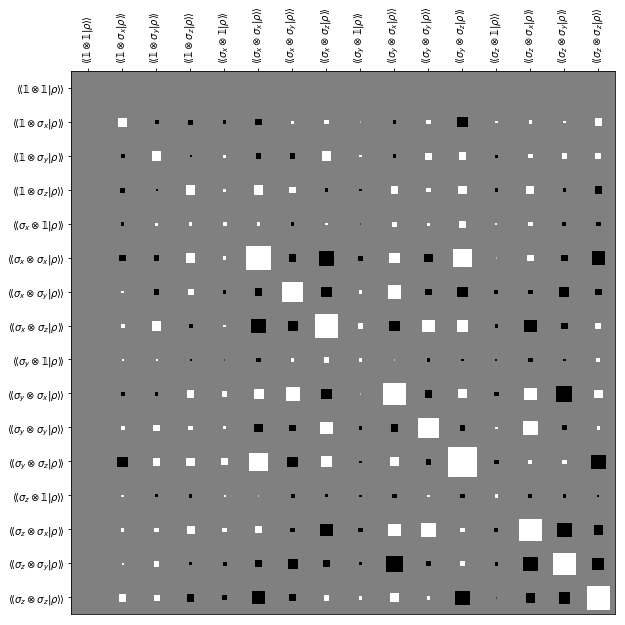

In [14]:
plt.figure(figsize=(10, 10))
updater.plot_covariance()
plt.xticks(rotation=90)


## Epilogue

In [15]:
for component, version in sorted(qsharp.component_versions().items(), key=lambda x: x[0]):
    print(f"{component:20}{version}")

.NET Runtime        .NETCoreApp,Version=v3.1
Jupyter Core        1.5.0.0
experimental        {'simulators': {'features': ['DEFAULT'], 'name': 'Microsoft.Quantum.Experimental.Simulators', 'opt_level': '3', 'target': 'x86_64-pc-windows-msvc', 'version': '0.18.2109162713'}}
iqsharp             0.18.2109162713
qsharp              0.18.2109.162713


In [16]:
import sys
print(sys.version)

3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
